In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import ensemble
from sklearn.decomposition import PCA
from matplotlib import rcParams
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import rcParams
from sklearn.feature_selection import SelectKBest
from scipy import stats
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

from sklearn import metrics

from google.colab import files
import io

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [0]:
# Set graph parameters
sns.set_style('whitegrid')
rcParams['figure.figsize'] = 10,7

In [3]:
uploaded = files.upload()

Saving cardio_train.csv to cardio_train.csv


In [109]:
df = pd.read_csv(io.BytesIO(uploaded['cardio_train.csv']), sep=';')
print(df.shape)
df.head()

(70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


### Some information about the features
- Age is currently measured in days
- Gender is classified 1:women and 2:men
- Height is measure in cm
- Weight is measured in kg 
- ap_hi refers to arterial pressure. Specifically the Systolic blood pressures which represents when the heart contracts.
- ap_lo refers to Dystolic Blood Pressure or when the heart contracts. 
    - ap_hi and ap_lo are used to calculate blood pressure (e.g. 120/80)
    - according to the CDC, less than 120/80 is considered normal, between 120/80 and 139/89 is considered at risk for high blood pressure, and more than 140/90 is considered high blood pressure.
- cholesterol and glu are labeled as 1:normal, 2:above normal, 3 well above normal.
- smoke, alco, active, and cardio are binary with cardio as the target

# Data Cleaning

In [110]:
# Change age to years for easier comprehension 
df['age'] = round(df['age'] / 365, 1)

# Add BMI metric for later
df['bmi'] = (df['weight'] / df['height'] / df['height']) * 10000

# Look at shape
print(df.shape)

# Look at general statitics
df.describe()

(70000, 14)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,53.339486,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,27.556513
std,28851.302323,6.759534,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.091511
min,0.000000,29.600000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.471784
25%,25006.750000,48.400000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115
50%,50001.500000,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.374068
75%,74889.250000,58.400000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.222222
max,99999.000000,65.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,298.666667


In [111]:
# Look for missing values
df.isnull().any()

id             False
age            False
gender         False
height         False
weight         False
ap_hi          False
ap_lo          False
cholesterol    False
gluc           False
smoke          False
alco           False
active         False
cardio         False
bmi            False
dtype: bool

There appears to be some outliers in the blood pressure features

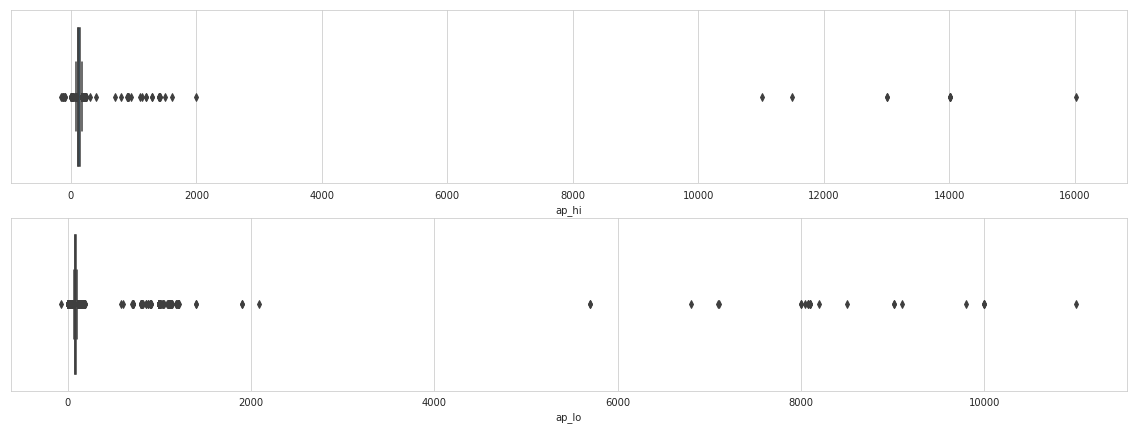

In [112]:
plt.figure(figsize=(20,7))
plt.subplot(211)
sns.boxplot(df['ap_hi'])
plt.subplot(212)
sns.boxplot(df['ap_lo'])

In [113]:
# Determine parameters for removing outliers and how many observations would be removed
print(df[df['ap_hi'] > 370].shape)
print(df[df['ap_lo'] > 360].shape)
print(df[df['ap_hi'] < 0].shape)
print(df[df['ap_lo'] < 0].shape)
print(df[df['ap_hi'] < df['ap_lo']].shape)


(39, 14)
(953, 14)
(7, 14)
(1, 14)
(1234, 14)


The number 370/360 is based off of a study involving blood pressure and seems to be one of the highest recorded

In [114]:
# Create copies for modeling 
df_clean = df.copy()
df_full = df.copy()

# Drop blood pressure outliers
df_clean.drop(df_clean[(df_clean['ap_hi']>370)].index,inplace=True)
df_clean.drop(df_clean[(df_clean['ap_lo']>360)].index,inplace=True)
df_clean.drop(df_clean[(df_clean['ap_hi']<0)].index,inplace=True)
df_clean.drop(df_clean[(df_clean['ap_lo']<0)].index,inplace=True)
df_clean.drop(df_clean[(df_clean['ap_hi']<df_clean['ap_lo'])].index,inplace=True)

first_cleaning = 1 - df_clean.shape[0] / df.shape[0]
print(df_clean.shape)
print('Percent of observations lost:', first_cleaning)

(68726, 14)
Percent of observations lost: 0.018199999999999994


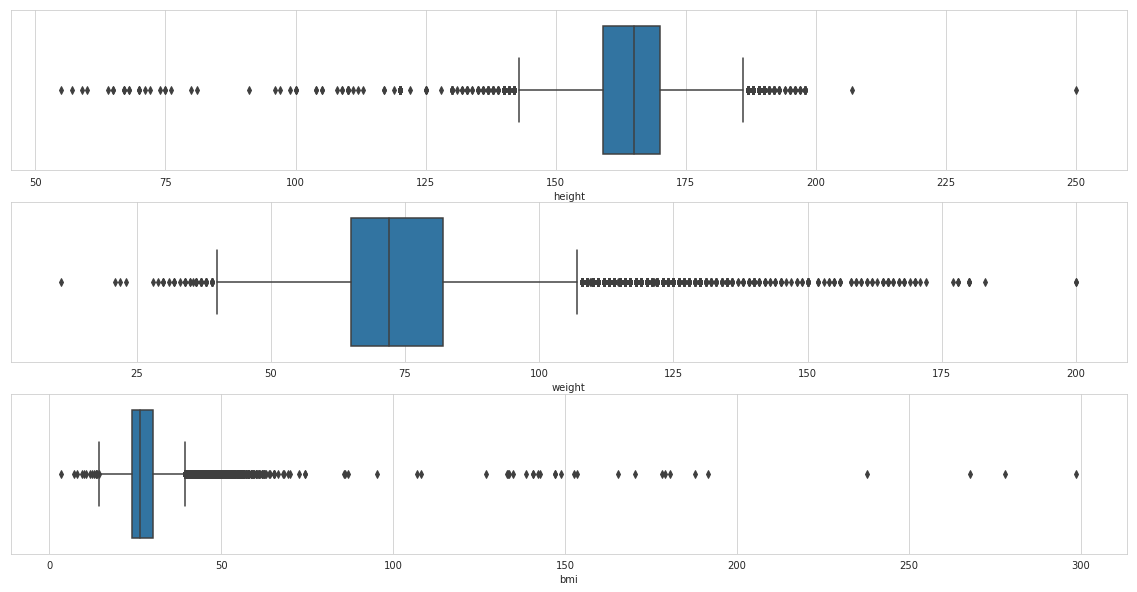

In [115]:
# Look at the outliers in weight and height
plt.figure(figsize=(20, 10))
plt.subplot(311)
sns.boxplot(df_clean['height'])
plt.subplot(312)
sns.boxplot(df_clean['weight'])
plt.subplot(313)
sns.boxplot(df_clean['bmi']);

In [68]:
# See what kind of impact removing these observations would make 
print(df_clean[df_clean['height'] < 145].shape)
print(df_clean[df_clean['height'] > 225].shape)
print(df_clean[df_clean['weight'] < 40].shape)
print(df_clean[df_clean['weight'] > 175].shape)
print(df_clean[df_clean['bmi'] > 45].shape)
print(df_clean[df_clean['bmi'] < 15].shape)

(361, 14)
(1, 14)
(49, 14)
(11, 14)
(579, 14)
(26, 14)


In [69]:
# Drop outliers from weight and height
df_clean.drop(df_clean[(df_clean['height'] < 145)].index,inplace=True)
df_clean.drop(df_clean[(df_clean['height'] > 225)].index,inplace=True)
df_clean.drop(df_clean[(df_clean['weight'] < 40)].index,inplace=True)
df_clean.drop(df_clean[(df_clean['weight'] > 175)].index,inplace=True)
df_clean.drop(df_clean[(df_clean['bmi'] > 45)].index,inplace=True)
df_clean.drop(df_clean[(df_clean['bmi'] < 15)].index,inplace=True)

# Determine percentage of outliers removed
print(df_clean.shape)
print('Percent missing from origianl:', 1 - df_clean.shape[0] / df.shape[0])
print('Total missing from origianl:', (1 - df_clean.shape[0] / df.shape[0]) + first_cleaning)


(67849, 14)
Percent missing from origianl: 0.03072857142857144
Total missing from origianl: 0.04892857142857143


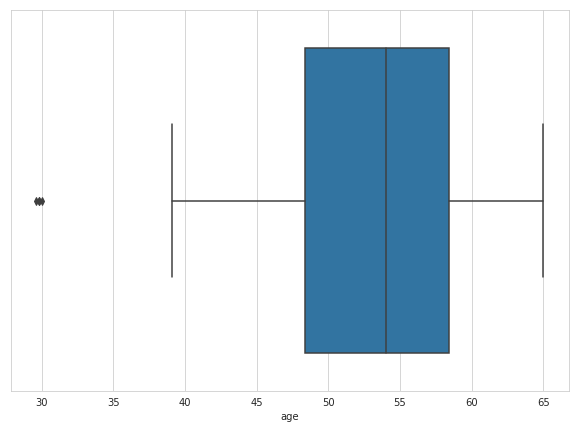

In [70]:
# Look at the outliers in age
sns.boxplot(df_clean['age'])

In [71]:
df_clean[df_clean['age']<35].shape

(4, 14)

In [0]:
df_clean.drop(df_clean[(df_clean['age']<35)].index,inplace=True)

# Exploratory Data Analysis

Text(0.5, 0, 'Age')

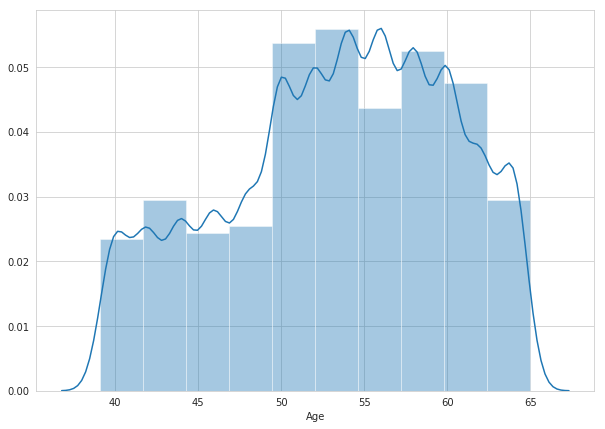

In [73]:
# Look at the distribution of age
sns.distplot(df_clean['age'], bins=10)
plt.xlabel('Age')

Here we can see that there are more individuals 50 years old or older in the dataset.

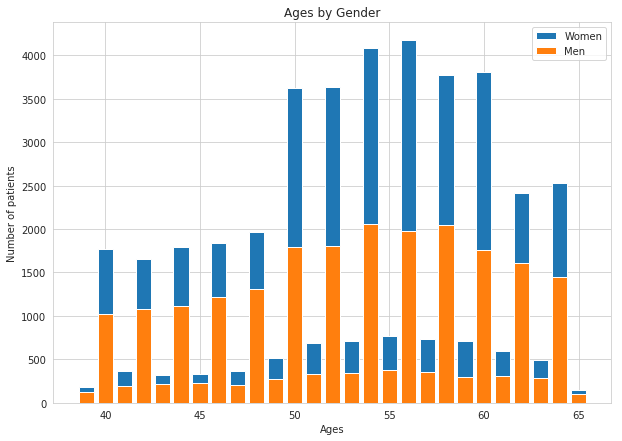

In [74]:
years = round(df_clean[df_clean['gender']==1]['age']).value_counts().index
ages_women = round(df_clean[df_clean['gender']==1]['age']).value_counts()
plt1 = plt.bar(years, ages_women)

years = round(df_clean[df_clean['gender']==2]['age']).value_counts().index
ages_men = round(df_clean[df_clean['gender']==2]['age']).value_counts()
plt2 = plt.bar(years, ages_men)

plt.ylabel('Number of patients')
plt.xlabel('Ages')
plt.title('Ages by Gender')
plt.legend((plt1[0], plt2[0]), ('Women', 'Men'))

plt.show()

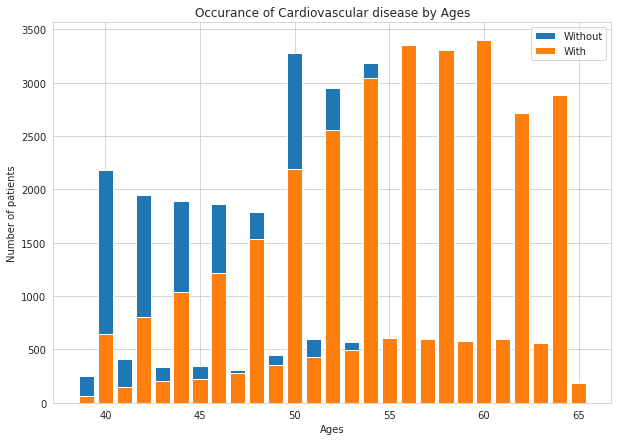

In [129]:
years = round(df_clean[df_clean['cardio']==0]['age']).value_counts().index
without_cardio = round(df_clean[df_clean['cardio']==0]['age']).value_counts()
plt1 = plt.bar(years, without_cardio)

years = round(df_clean[df_clean['cardio']==1]['age']).value_counts().index
with_cardio = round(df_clean[df_clean['cardio']==1]['age']).value_counts()
plt2 = plt.bar(years, with_cardio)

plt.ylabel('Number of patients')
plt.xlabel('Ages')
plt.title('Occurance of Cardiovascular disease by Ages')
plt.legend((plt1[0], plt2[0]), ('Without', 'With'))

plt.show()

In [76]:
print(df_clean.shape)
print(df_full.shape)

(67845, 14)
(70000, 14)


In [82]:
for col in df_clean.drop(['id', 'cardio'],1):
  print(col)
  print(stats.ttest_ind(df_clean[col], df_clean['cardio']))
  print()

age
Ttest_indResult(statistic=2030.051565466351, pvalue=0.0)

gender
Ttest_indResult(statistic=323.3514028517935, pvalue=0.0)

height
Ttest_indResult(statistic=5536.385895833184, pvalue=0.0)

weight
Ttest_indResult(statistic=1413.2133645689285, pvalue=0.0)

ap_hi
Ttest_indResult(statistic=1971.1022173074853, pvalue=0.0)

ap_lo
Ttest_indResult(statistic=2186.7122547755685, pvalue=0.0)

cholesterol
Ttest_indResult(statistic=268.95672617845776, pvalue=0.0)

gluc
Ttest_indResult(statistic=251.08516699859337, pvalue=0.0)

smoke
Ttest_indResult(statistic=-183.34760756899348, pvalue=0.0)

alco
Ttest_indResult(statistic=-208.8769452502856, pvalue=0.0)

active
Ttest_indResult(statistic=126.52658431753486, pvalue=0.0)

bmi
Ttest_indResult(statistic=1434.566064880124, pvalue=0.0)



,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
id,1.000000,0.002902,0.003139,-0.001588,-0.000543,0.001205,-0.000176,0.005843,0.001711,-0.003872,-0.000039,0.004372,0.003792,-0.000158
age,0.002902,1.000000,-0.021873,-0.084134,0.059509,0.209090,0.154374,0.154606,0.098826,-0.047389,-0.027944,-0.010373,0.239598,0.109513
gender,0.003139,-0.021873,1.000000,0.524924,0.175220,0.065263,0.068414,-0.034841,-0.020017,0.338802,0.170682,0.005962,0.009026,-0.105108
height,-0.001588,-0.084134,0.524924,1.000000,0.336564,0.021877,0.037776,-0.054610,-0.019787,0.197178,0.097928,-0.009540,-0.010101,-0.187712
weight,-0.000543,0.059509,0.175220,0.336564,1.000000,0.265837,0.246969,0.139583,0.101264,0.072795,0.070222,-0.018355,0.180972,0.857462
ap_hi,0.001205,0.209090,0.065263,0.021877,0.265837,1.000000,0.718918,0.193291,0.090929,0.028917,0.036046,-0.000784,0.427161,0.265494
ap_lo,-0.000176,0.154374,0.068414,0.037776,0.246969,0.718918,1.000000,0.157133,0.071923,0.025993,0.036688,-0.001083,0.333852,0.237399
cholesterol,0.005843,0.154606,-0.034841,-0.054610,0.139583,0.193291,0.157133,1.000000,0.449042,0.010352,0.035805,0.008794,0.221063,0.174176
gluc,0.001711,0.098826,-0.020017,-0.019787,0.101264,0.090929,0.071923,0.449042,1.000000,-0.006202,0.010021,-0.007303,0.088505,0.115320
smoke,-0.003872,-0.047389,0.338802,0.197178,0.072795,0.028917,0.025993,0.010352,-0.006202,1.000000,0.341497,0.025311,-0.015902,-0.031981


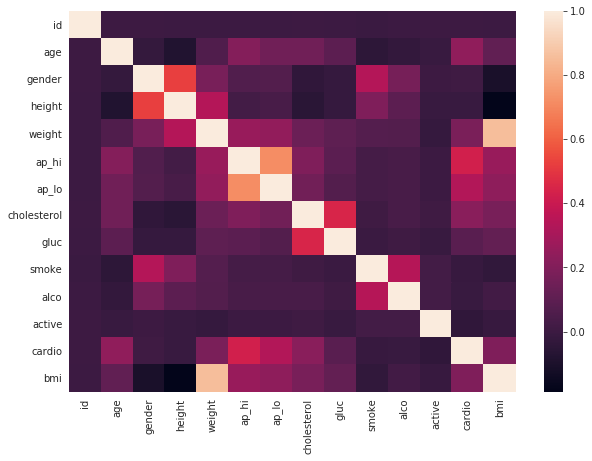

In [85]:
corrmat = df_clean.corr()
sns.heatmap(corrmat)
corrmat

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
age,1.000000,-0.021873,-0.084134,0.059509,0.209090,0.154374,0.154606,0.098826,-0.047389,-0.027944,-0.010373
gender,-0.021873,1.000000,0.524924,0.175220,0.065263,0.068414,-0.034841,-0.020017,0.338802,0.170682,0.005962
height,-0.084134,0.524924,1.000000,0.336564,0.021877,0.037776,-0.054610,-0.019787,0.197178,0.097928,-0.009540
weight,0.059509,0.175220,0.336564,1.000000,0.265837,0.246969,0.139583,0.101264,0.072795,0.070222,-0.018355
ap_hi,0.209090,0.065263,0.021877,0.265837,1.000000,0.718918,0.193291,0.090929,0.028917,0.036046,-0.000784
ap_lo,0.154374,0.068414,0.037776,0.246969,0.718918,1.000000,0.157133,0.071923,0.025993,0.036688,-0.001083
cholesterol,0.154606,-0.034841,-0.054610,0.139583,0.193291,0.157133,1.000000,0.449042,0.010352,0.035805,0.008794
gluc,0.098826,-0.020017,-0.019787,0.101264,0.090929,0.071923,0.449042,1.000000,-0.006202,0.010021,-0.007303
smoke,-0.047389,0.338802,0.197178,0.072795,0.028917,0.025993,0.010352,-0.006202,1.000000,0.341497,0.025311
alco,-0.027944,0.170682,0.097928,0.070222,0.036046,0.036688,0.035805,0.010021,0.341497,1.000000,0.025169


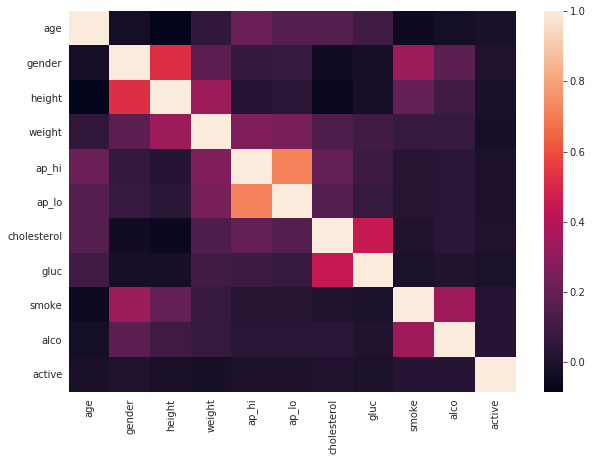

In [87]:
# Create features and target variables
X_clean = df_clean.drop(['id', 'cardio', 'bmi'], 1)
y_clean = df_clean.cardio

X_full = df_full.drop(['id', 'cardio', 'bmi'], 1)
y_full = df_full['cardio']

# Look at a correlation matrix and heatmap of correlation between feature variables
corrmat_clean = X_clean.corr()
sns.heatmap(corrmat_clean);
corrmat_clean

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
age,1.000000,-0.022794,-0.081522,0.053654,0.020778,0.017630,0.154394,0.098672,-0.047638,-0.029730,-0.009931
gender,-0.022794,1.000000,0.499033,0.155406,0.006005,0.015254,-0.035821,-0.020491,0.338135,0.170966,0.005866
height,-0.081522,0.499033,1.000000,0.290968,0.005488,0.006150,-0.050226,-0.018595,0.187989,0.094419,-0.006570
weight,0.053654,0.155406,0.290968,1.000000,0.030702,0.043710,0.141768,0.106857,0.067780,0.067113,-0.016867
ap_hi,0.020778,0.006005,0.005488,0.030702,1.000000,0.016086,0.023778,0.011841,-0.000922,0.001408,-0.000033
ap_lo,0.017630,0.015254,0.006150,0.043710,0.016086,1.000000,0.024019,0.010806,0.005186,0.010601,0.004780
cholesterol,0.154394,-0.035821,-0.050226,0.141768,0.023778,0.024019,1.000000,0.451578,0.010354,0.035760,0.009911
gluc,0.098672,-0.020491,-0.018595,0.106857,0.011841,0.010806,0.451578,1.000000,-0.004756,0.011246,-0.006770
smoke,-0.047638,0.338135,0.187989,0.067780,-0.000922,0.005186,0.010354,-0.004756,1.000000,0.340094,0.025858
alco,-0.029730,0.170966,0.094419,0.067113,0.001408,0.010601,0.035760,0.011246,0.340094,1.000000,0.025476


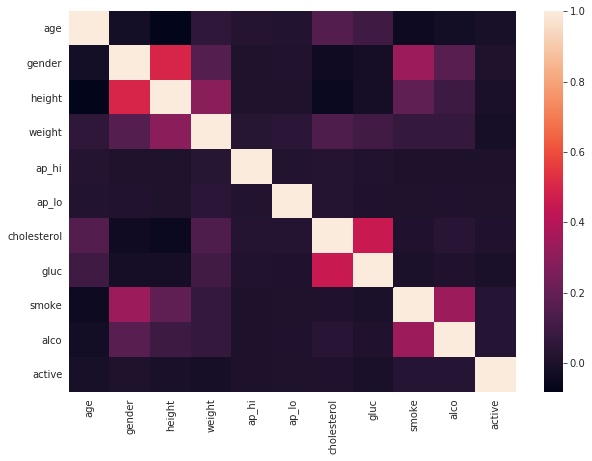

In [88]:
corrmat_full = X_full.corr()
sns.heatmap(corrmat_full);
corrmat_full

# Modeling


### Feature Selection

In [89]:
X_new = SelectKBest(k=10).fit_transform(X_clean, y_clean)
Kbest_X_clean = pd.DataFrame(X_new)
Kbest_X_clean.head()

,0,1,2,3,4,5,6,7,8,9
0,50.4,2.0,168.0,62.0,110.0,80.0,1.0,1.0,0.0,1.0
1,55.4,1.0,156.0,85.0,140.0,90.0,3.0,1.0,0.0,1.0
2,51.7,1.0,165.0,64.0,130.0,70.0,3.0,1.0,0.0,0.0
3,48.3,2.0,169.0,82.0,150.0,100.0,1.0,1.0,0.0,1.0
4,47.9,1.0,156.0,56.0,100.0,60.0,1.0,1.0,0.0,0.0


In [90]:
X_new = SelectKBest(k=10).fit_transform(X_full, y_full)
Kbest_X_full = pd.DataFrame(X_new)
Kbest_X_full.head()

,0,1,2,3,4,5,6,7,8,9
0,50.4,2.0,168.0,62.0,110.0,80.0,1.0,1.0,0.0,1.0
1,55.4,1.0,156.0,85.0,140.0,90.0,3.0,1.0,0.0,1.0
2,51.7,1.0,165.0,64.0,130.0,70.0,3.0,1.0,0.0,0.0
3,48.3,2.0,169.0,82.0,150.0,100.0,1.0,1.0,0.0,1.0
4,47.9,1.0,156.0,56.0,100.0,60.0,1.0,1.0,0.0,0.0


In [91]:
pca = PCA(n_components=10)
x_pca_clean = pca.fit_transform(X_clean)
pca.explained_variance_ratio_

array([5.49094299e-01, 2.51837359e-01, 7.85178649e-02, 6.26661939e-02,
       5.60708514e-02, 8.20622435e-04, 3.10950572e-04, 2.69778296e-04,
       2.38904936e-04, 1.14063938e-04])

In [92]:
pca = PCA(n_components=10)
x_pca_full = pca.fit_transform(X_full)
pca.explained_variance_ratio_

array([5.96691559e-01, 3.97918914e-01, 3.60578851e-03, 1.03112102e-03,
       7.32200056e-04, 9.30147470e-06, 3.47144302e-06, 3.08753600e-06,
       2.64054962e-06, 1.25999276e-06])

In [0]:
def model_analysis(model, X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)
  model.fit(X_train, y_train)
  
  y_pred = model.predict(X_test)
  print(metrics.confusion_matrix(y_test, y_pred))
  
  r_squared = model.score(X_test, y_test)
  accuracy = metrics.f1_score(y_test, y_pred)
  
  print('r-squared:', r_squared)
  print('f1:', accuracy)
  
  return [r_squared, accuracy]

### Naive Bayes

In [119]:
bnb = BernoulliNB()

print('Cleaned data')
print('All features')
clean_bnb_all = model_analysis(bnb, X_clean, y_clean)
print()
print('PCA')
clean_bnb_pca = model_analysis(bnb, x_pca_clean, y_clean)
print()
print('K_best')
clean_bnb_kbest = model_analysis(bnb, Kbest_X_clean, y_clean)

Cleaned data
All features
[[8437 1865]
 [7901 2151]]
r-squared: 0.5201925911368773
f1: 0.305800398066534

PCA
[[7830 2493]
 [3375 6656]]
r-squared: 0.7117028593888179
f1: 0.6940563086548488

K_best
[[8425 1830]
 [7942 2157]]
r-squared: 0.5198978087845141
f1: 0.3062615362771546


In [120]:
bnb = BernoulliNB()

print('Full data')
print('All features')
full_bnb_all = logreg_scores = model_analysis(bnb, X_full, y_full)
print()
print('PCA')
full_bnb_pca = model_analysis(bnb, x_pca_full, y_full)
print()
print('K_best')
full_bnb_kbest = model_analysis(bnb, Kbest_X_full, y_full)

Full data
All features
[[8658 1882]
 [8274 2186]]
r-squared: 0.5163809523809524
f1: 0.3009361233480176

PCA
[[8068 2380]
 [3481 7071]]
r-squared: 0.7209047619047619
f1: 0.7069939509073639

K_best
[[8550 1920]
 [8298 2232]]
r-squared: 0.5134285714285715
f1: 0.30404577033101754


### Logistic Regression

first model without removing any observations 

In [94]:
logreg = LogisticRegression()

print('Cleaned data')
print('All features')
clean_log_all = model_analysis(logreg, X_clean, y_clean)
print()
print('PCA')
clean_log_pca = model_analysis(logreg, x_pca_clean, y_clean)
print()
print('K_best')
clean_log_kbest = model_analysis(logreg, Kbest_X_clean, y_clean)

Cleaned data
All features
[[8088 2216]
 [3402 6648]]
r-squared: 0.72398545740395
f1: 0.7029713439780058

PCA
[[8165 2164]
 [3350 6675]]
r-squared: 0.7290950181782451
f1: 0.7076972010178119

K_best
[[8126 2222]
 [3305 6701]]
r-squared: 0.7284563230814581
f1: 0.7080141581700037


In [95]:
logreg = LogisticRegression()

print('Full data')
print('All features')
full_log_all = logreg_scores = model_analysis(logreg, X_full, y_full)
print()
print('PCA')
full_log_pca = model_analysis(logreg, x_pca_full, y_full)
print()
print('K_best')
full_log_kbest = model_analysis(logreg, Kbest_X_full, y_full)

Full data
All features
[[8006 2555]
 [3291 7148]]
r-squared: 0.7216190476190476
f1: 0.7097606990368386

PCA
[[8122 2452]
 [3391 7035]]
r-squared: 0.7217619047619047
f1: 0.706573595138854

K_best
[[8013 2461]
 [3328 7198]]
r-squared: 0.7243333333333334
f1: 0.7132028734208571


### Random Forest

In [96]:
# random forest
rfc = ensemble.RandomForestClassifier()

print('Cleaned Data')
print('All features')
clean_rfc_all = model_analysis(rfc, X_clean, y_clean)
print()
print('PCA')
clean_rfc_pca = model_analysis(rfc, x_pca_clean, y_clean)
print()
print('K_best')
clean_rfc_kbest = model_analysis(rfc, Kbest_X_clean, y_clean)

Cleaned Data
All features
[[7725 2681]
 [3462 6486]]
r-squared: 0.6981920015721725
f1: 0.6786293486790479

PCA
[[7588 2727]
 [3555 6484]]
r-squared: 0.691362877075759
f1: 0.6736623376623377

K_best
[[7712 2567]
 [3572 6503]]
r-squared: 0.6983885231404147
f1: 0.6793418647166362


In [97]:
# random forest
rfc = ensemble.RandomForestClassifier()

print('Full data')
print('All features')
full_rfc_all = rfc_scores = model_analysis(rfc, X_full, y_full)
print()
print('PCA')
full_rfc_pca = model_analysis(rfc, x_pca_full, y_full)
print()
print('K_best')
full_rfc_kbest = model_analysis(rfc, Kbest_X_full, y_full)

Full data
All features
[[7771 2708]
 [3642 6879]]
r-squared: 0.6976190476190476
f1: 0.684205291426298

PCA
[[7854 2724]
 [3598 6824]]
r-squared: 0.698952380952381
f1: 0.6834251377065598

K_best
[[7703 2776]
 [3617 6904]]
r-squared: 0.6955714285714286
f1: 0.6835305182911737


### K Nearest Neighbors

In [98]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

# Normalize data for Euclidean geometry

print('Cleaned data')
print('All features')
clean_knn_all = model_analysis(knn, normalize(X_clean), y_clean)
print()
print('PCA')
clean_knn_pca = model_analysis(knn, normalize(x_pca_clean), y_clean)
print()
print('K_best')
clean_knn_kbest = model_analysis(knn, normalize(Kbest_X_clean), y_clean)

Cleaned data
All features
[[7302 3048]
 [3467 6537]]
r-squared: 0.6799154957256559
f1: 0.667415386186125

PCA
[[7227 3042]
 [3380 6705]]
r-squared: 0.684484622187285
f1: 0.6761799112545381

K_best
[[7266 3059]
 [3424 6605]]
r-squared: 0.6814876682715928
f1: 0.6707967298024679


In [99]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

# Normalize data for Euclidean geometry

print('Full Data')
print('All features')
full_knn_all = model_analysis(knn, normalize(X_full), y_full)
print()
print('PCA')
full_knn_pca = model_analysis(knn, normalize(x_pca_full), y_full)
print()
print('K_best')
full_knn_kbest = model_analysis(knn, normalize(Kbest_X_full), y_full)

Full Data
All features
[[7355 3180]
 [3428 7037]]
r-squared: 0.6853333333333333
f1: 0.680495116526448

PCA
[[7405 3087]
 [3521 6987]]
r-squared: 0.6853333333333333
f1: 0.6789427655232727

K_best
[[7295 3230]
 [3454 7021]]
r-squared: 0.6817142857142857
f1: 0.6775065135578501


### Gradient Boosting Classifier

In [100]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
gbc = ensemble.GradientBoostingClassifier(**params)

print('Cleaned data')
print('All features')
clean_gbc_all = model_analysis(gbc, X_clean, y_clean)
print()
print('PCA')
clean_gbc_pca = model_analysis(gbc, x_pca_clean, y_clean)
print()
print('K_best')
clean_gbc_kbest = model_analysis(gbc, Kbest_X_clean, y_clean)

Cleaned data
All features
[[7940 2371]
 [3057 6986]]
r-squared: 0.7333202318954505
f1: 0.7202061855670103

PCA
[[7913 2291]
 [3150 7000]]
r-squared: 0.7326815367986637
f1: 0.7201275654544519

K_best
[[8012 2324]
 [3007 7011]]
r-squared: 0.7380858799253218
f1: 0.7245388311889629


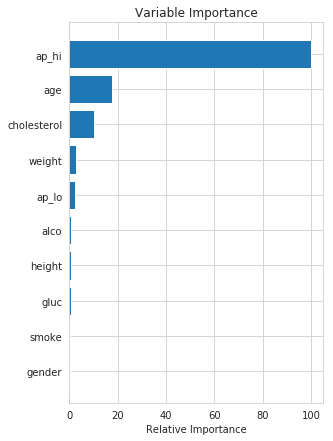

In [102]:
feature_importance = gbc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_clean.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [103]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
gbc = ensemble.GradientBoostingClassifier(**params)

print('Full Data')
print('All features')
full_gbc_all = model_analysis(gbc, X_full, y_full)
print()
print('PCA')
full_gbc_pca = model_analysis(gbc, x_pca_full, y_full)
print()
print('K_best')
full_gbc_kbest = model_analysis(gbc, Kbest_X_full, y_full)

Full Data
All features
[[8124 2451]
 [3074 7351]]
r-squared: 0.736904761904762
f1: 0.7268502496662876

PCA
[[8166 2369]
 [3224 7241]]
r-squared: 0.7336666666666667
f1: 0.7213947696139477

K_best
[[7957 2432]
 [3146 7465]]
r-squared: 0.7343809523809524
f1: 0.7280085820167739


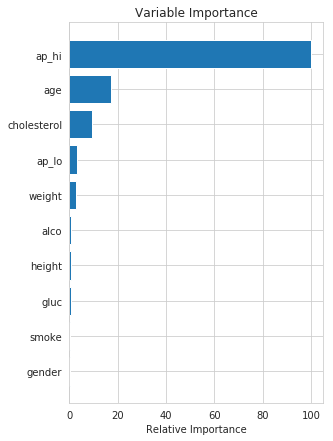

In [104]:
feature_importance = gbc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_full.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### SVC

In [121]:
svc = SVC()

# Normalize data for Euclidean geometry

print('Cleaned data')
print('All features')
clean_svc_all = model_analysis(svc, normalize(X_clean), y_clean)
print()
print('PCA')
clean_svc_pca = model_analysis(svc, normalize(x_pca_clean), y_clean)
print()
print('K_best')
clean_svc_kbest = model_analysis(svc, normalize(Kbest_X_clean), y_clean)

Cleaned data
All features
[[8181 2058]
 [3980 6135]]
r-squared: 0.703350692738528
f1: 0.670198820187896

PCA
[[8298 2067]
 [3506 6483]]
r-squared: 0.7261963250466739
f1: 0.6993904741356061

K_best
[[8211 2114]
 [3829 6200]]
r-squared: 0.7080180799842782
f1: 0.676007196205637


In [117]:
svc = SVC()

# Normalize data for Euclidean geometry

print('Full Data')
print('All features')
full_svc_all = model_analysis(svc, normalize(X_full), y_full)
print()
print('PCA')
full_svc_pca = model_analysis(svc, normalize(x_pca_full), y_full)
print()
print('K_best')
full_svc_kbest = model_analysis(svc, normalize(Kbest_X_full), y_full)

Full Data
All features
[[8289 2196]
 [4074 6441]]
r-squared: 0.7014285714285714
f1: 0.6726190476190476

PCA
[[8566 1917]
 [3834 6683]]
r-squared: 0.7261428571428571
f1: 0.6991682795417691

K_best
[[8259 2256]
 [4018 6467]]
r-squared: 0.7012380952380952
f1: 0.6733652644731363


In [105]:
results_clean = pd.DataFrame(index=['r-squared', 'f1'])

results_clean['clean log all'] = clean_log_all
results_clean['clean log pca'] = clean_log_pca
results_clean['clean log kbest'] = clean_log_kbest
results_clean['clean rfc all'] = clean_rfc_all
results_clean['clean rfc pca'] = clean_rfc_pca
results_clean['clean rfc kbest'] = clean_rfc_kbest
results_clean['clean knn all'] = clean_knn_all
results_clean['clean knn pca'] = clean_knn_pca
results_clean['clean knn kbest'] = clean_knn_kbest
results_clean['clean gbc all'] = clean_gbc_all
results_clean['clean gbc pca'] = clean_gbc_pca
results_clean['clean gbc kbest'] = clean_gbc_kbest

results_clean.head()


,clean log all,clean log pca,clean log kbest,clean rfc all,clean rfc pca,clean rfc kbest,clean knn all,clean knn pca,clean knn kbest,clean gbc all,clean gbc pca,clean gbc kbest
r-squared,0.723985,0.729095,0.728456,0.698192,0.691363,0.698389,0.679915,0.684485,0.681488,0.733320,0.732682,0.738086
f1,0.702971,0.707697,0.708014,0.678629,0.673662,0.679342,0.667415,0.676180,0.670797,0.720206,0.720128,0.724539


In [106]:
results_full = pd.DataFrame(index=['r-squared', 'f1'])

results_full['Full log all'] = full_log_all
results_full['Full log pca'] = full_log_pca
results_full['Full log kbest'] = full_log_kbest
results_full['Full rfc all'] = full_rfc_all
results_full['Full rfc pca'] = full_rfc_pca
results_full['Full rfc kbest'] = full_rfc_kbest
results_full['Full knn all'] = full_knn_all
results_full['Full knn pca'] = full_knn_pca
results_full['Full knn kbest'] = full_knn_kbest
results_full['Full gbc all'] = full_gbc_all
results_full['Full gbc pca'] = full_gbc_pca
results_full['Full gbc kbest'] = full_gbc_kbest

results_full.head()


,Full log all,Full log pca,Full log kbest,Full rfc all,Full rfc pca,Full rfc kbest,Full knn all,Full knn pca,Full knn kbest,Full gbc all,Full gbc pca,Full gbc kbest
r-squared,0.721619,0.721762,0.724333,0.697619,0.698952,0.695571,0.685333,0.685333,0.681714,0.736905,0.733667,0.734381
f1,0.709761,0.706574,0.713203,0.684205,0.683425,0.683531,0.680495,0.678943,0.677507,0.726850,0.721395,0.728009
